# Практическая работа №1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Визуализация

In [3]:
data = pd.read_csv('./HH Spot Price.csv')

In [4]:
data.head()

,Unnamed: 0,"Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)"
0,1997 01,3.45
1,1997 02,2.15
2,1997 03,1.89
3,1997 04,2.03
4,1997 05,2.25


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 2 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Unnamed: 0                                                           291 non-null    object 
 1   Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)  291 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.7+ KB
None


In [6]:
data.rename(columns = {'Unnamed: 0':'Date'}, inplace=True)

In [7]:
# Удаляем пробелы
print(data['Date'].head(1).tolist())

data['Date'] = data['Date'].str.strip()

['1997 01 ']


In [8]:
# Преобразуем в формат даты
data['Date'] = pd.to_datetime(data['Date'], format='%Y %m')
print(data)

          Date  \
0   1997-01-01   
1   1997-02-01   
2   1997-03-01   
3   1997-04-01   
4   1997-05-01   
..         ...   
286 2020-11-01   
287 2020-12-01   
288 2021-01-01   
289 2021-02-01   
290 2021-03-01   

     Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)  
0                                                 3.45                    
1                                                 2.15                    
2                                                 1.89                    
3                                                 2.03                    
4                                                 2.25                    
..                                                 ...                    
286                                               2.61                    
287                                               2.59                    
288                                               2.71                    
289                              

## Предварительная обработка

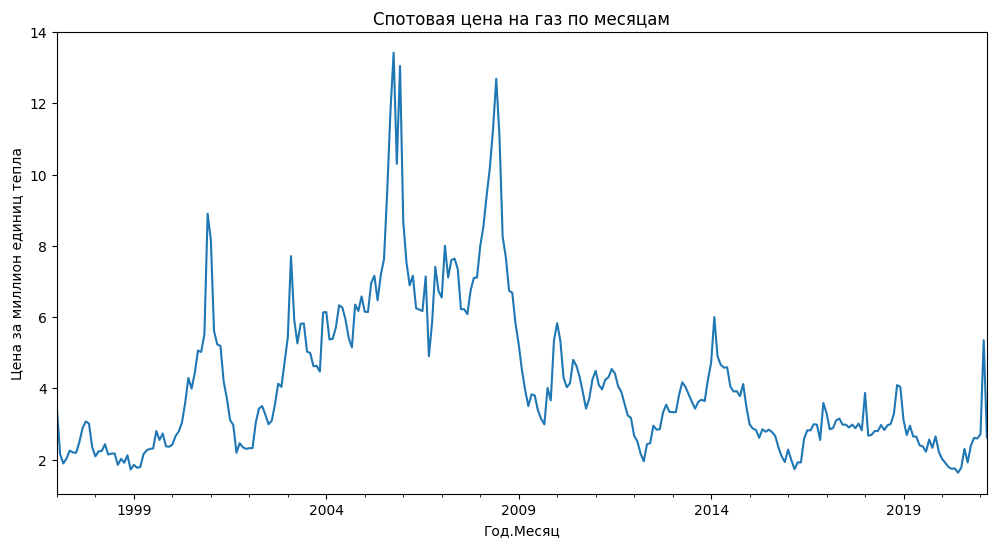

In [9]:
data1 = data.set_index('Date')

graph = data1.plot(figsize = (12,6), legend=None)

graph.set(title = 'Спотовая цена на газ по месяцам', 
          xlabel = 'Год.Месяц', 
          ylabel = 'Цена за миллион единиц тепла');

In [10]:
# Восстановление пропусков во временных рядах
print(data1.isnull().sum())

Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)    0
dtype: int64


In [11]:
# Проверка частоты дискретизации
frequency = pd.infer_freq(data['Date'])
print(f"Частота дискретизации: {frequency}")

Частота дискретизации: MS


In [12]:
differences = data1.index.to_series().diff().values
print(np.unique(differences))

[2419200000000000 2505600000000000 2592000000000000 2678400000000000
            'NaT']


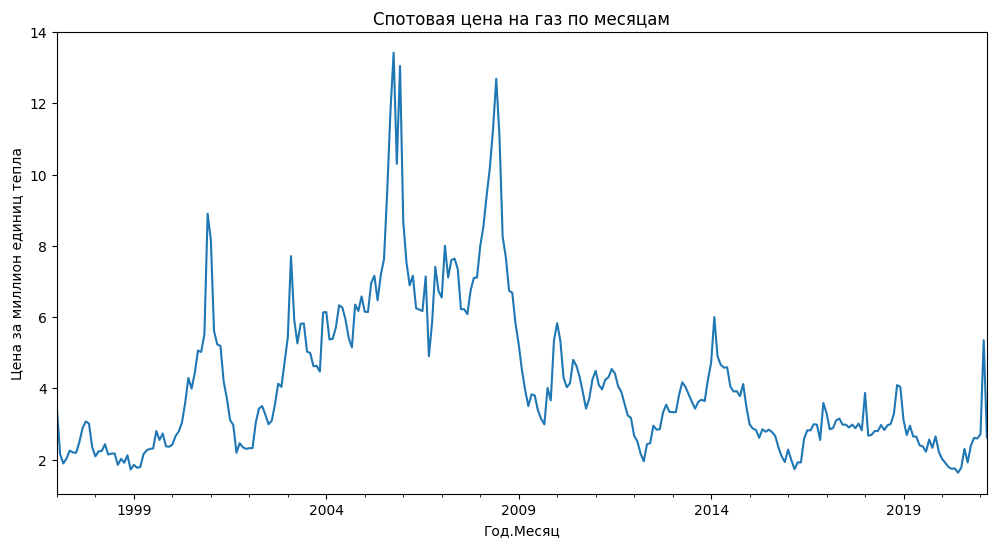

In [13]:
series = data1['Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)']

graph = series.plot(figsize = (12,6), legend=None)

graph.set(title = 'Спотовая цена на газ по месяцам', 
          xlabel = 'Год.Месяц', 
          ylabel = 'Цена за миллион единиц тепла');

In [14]:
# Выявление и устранение аномалий по критерию Ирвина
diffs = series.diff().abs().dropna()
print(diffs)

Date
1997-02-01    1.30
1997-03-01    0.26
1997-04-01    0.14
1997-05-01    0.22
1997-06-01    0.05
              ... 
2020-11-01    0.22
2020-12-01    0.02
2021-01-01    0.12
2021-02-01    2.64
2021-03-01    2.73
Name: Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu), Length: 290, dtype: float64


In [15]:
mean_diff = diffs.mean()
std_diff = diffs.std()

print(mean_diff)
print(std_diff)

0.46431034482758615
0.6076117866562643


In [16]:
threshold = mean_diff + std_diff

print(threshold)

1.0719221314838503


Аномалии по критерию Ирвина:
Date
1997-02-01     2.15
2000-12-01     8.90
2001-02-01     5.61
2003-02-01     7.71
2003-03-01     5.93
2003-12-01     6.13
2004-10-01     6.35
2005-08-01     9.53
2005-09-01    11.75
2005-10-01    13.42
2005-11-01    10.30
2005-12-01    13.05
2006-01-01     8.69
2006-02-01     7.54
2006-09-01     4.90
2006-11-01     7.41
2007-02-01     8.00
2007-07-01     6.22
2008-05-01    11.27
2008-06-01    12.69
2008-07-01    11.09
2008-08-01     8.26
2009-12-01     5.35
2014-02-01     6.00
2014-03-01     4.90
2018-02-01     2.67
2021-02-01     5.35
2021-03-01     2.62
Name: Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu), dtype: float64


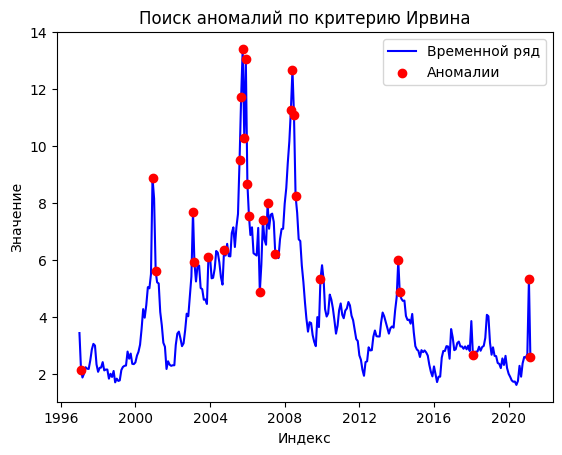

In [17]:
anomalies_irwin = series[1::][diffs > threshold]

print("Аномалии по критерию Ирвина:")
print(anomalies_irwin)

plt.plot(series, label='Временной ряд', color='blue')

plt.scatter(anomalies_irwin.index, anomalies_irwin, color='red', label='Аномалии', zorder=5)

plt.title('Поиск аномалий по критерию Ирвина')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

Аномалии lof:
            Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)
Date                                                                           
1998-12-01                                               1.72                  
2000-12-01                                               8.90                  
2001-01-01                                               8.17                  
2005-08-01                                               9.53                  
2005-09-01                                              11.75                  
2005-10-01                                              13.42                  
2005-11-01                                              10.30                  
2005-12-01                                              13.05                  
2006-01-01                                               8.69                  
2008-02-01                                               8.54                  
2008-03-01                

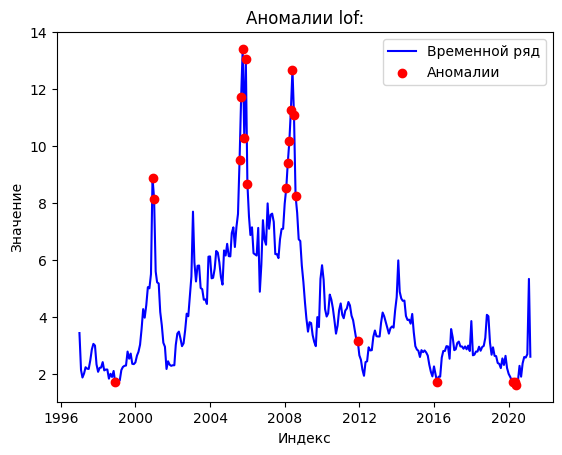

In [18]:
# Выявление аномалий lof
lof = LocalOutlierFactor(n_neighbors=25, contamination=0.07)
predictions = lof.fit_predict(data1)

anomalies_lof = data1[predictions == -1]
print("Аномалии lof:")
print(anomalies_lof)

plt.plot(data1, label='Временной ряд', color='blue')

plt.scatter(anomalies_lof.index, anomalies_lof, color='red', label='Аномалии', zorder=5)

plt.title('Аномалии lof:')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

In [19]:
data_with_nans = data1.copy()
data_with_nans[predictions == -1] = np.nan

# Применение сплайновой кубической интерполяции
data_interpolated = data_with_nans.interpolate(method='spline', order=3)

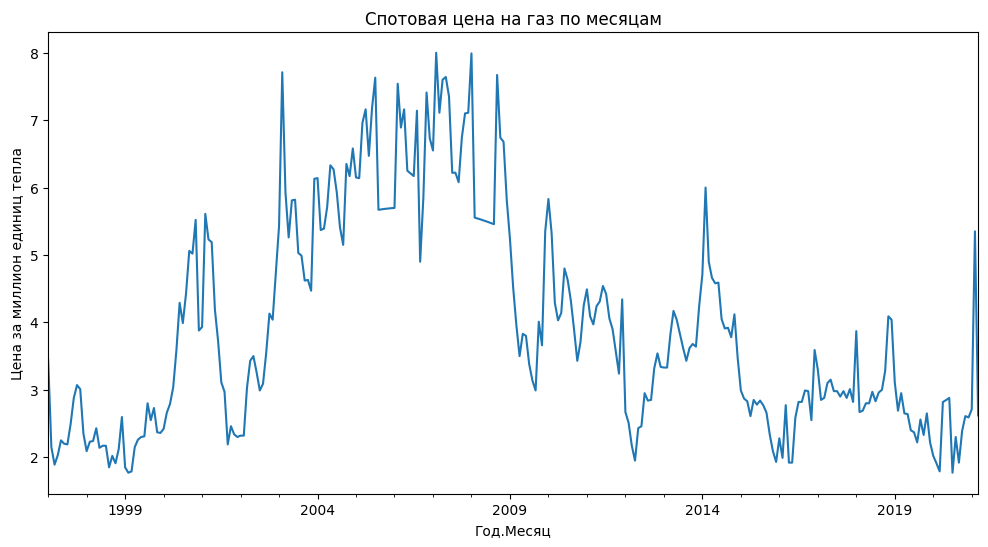

In [20]:
graph_interpolated = data_interpolated.plot(figsize = (12,6), legend=None)

graph_interpolated.set(title = 'Спотовая цена на газ по месяцам', 
          xlabel = 'Год.Месяц', 
          ylabel = 'Цена за миллион единиц тепла');

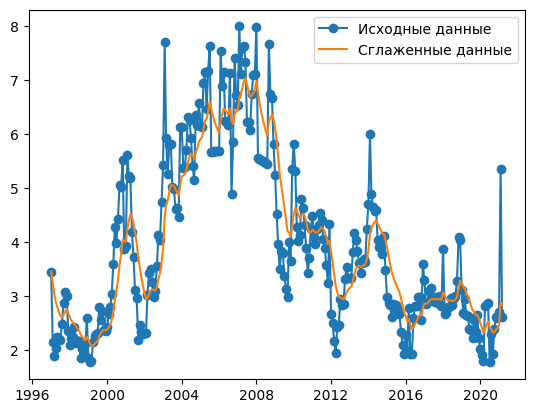

In [21]:
# Сглаживание временного ряда (метод экспоненциального сглаживания)
data_smoothed = data_interpolated.copy()
series = data_smoothed['Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)']

alpha = 0.15

smoothed_series = []

smoothed_series.append(series.iloc[0])

# Применение экспоненциального сглаживания
for i in range(1, len(series)):
    smoothed_value = alpha * series.iloc[i] + (1 - alpha) * smoothed_series[i-1]
    smoothed_series.append(smoothed_value)

smoothed_series = pd.Series(smoothed_series)

data_smoothed['Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)'] = smoothed_series.values

plt.plot(data_interpolated, label='Исходные данные', marker='o')
plt.plot(data_smoothed, label='Сглаженные данные', linestyle='-')
plt.legend()
plt.show()


## Проверка на стационарность

In [22]:
# Тест Дики-Фуллера

fuller_test = adfuller(data_interpolated)

print(f"ADF Statistic: {fuller_test[0]}")
print(f"p-value: {fuller_test[1]}")
for key, value in fuller_test[4].items():
    print(f'Critical Value ({key}): {value}')

ADF Statistic: -2.6287977552307833
p-value: 0.08719021367717916
Critical Value (1%): -3.453261605529366
Critical Value (5%): -2.87162848654246
Critical Value (10%): -2.5721455328896603


In [23]:
# Ряд нестационарен, т.к. p-value > 0.05. Значение статистики довольно высокое, следовательно, 
# вероятность, что ряд стационарен мала.

Text(0.5, 1.0, 'ACF')

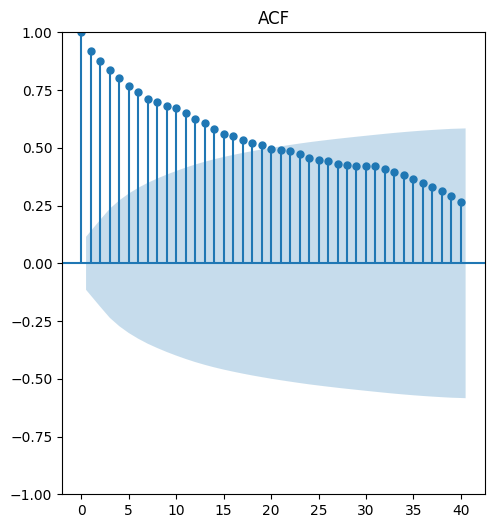

In [24]:
# ACF (автокорреляционная функция)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_interpolated, lags=40, ax=plt.gca())
plt.title('ACF')

На графике автокорреляционной функции видны незначительные пики через каждые 10 лагов, что может говорить о незначительной сезонности каждый 10 лаг.
Т.к. значения убывают медленно, это может говорить о наличии тренда.

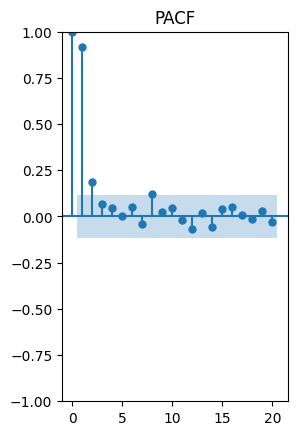

In [25]:
# PACF (частичная автокорреляционная функция)

plt.subplot(122)
plot_pacf(data_interpolated, lags=20, ax=plt.gca())
plt.title('PACF')
plt.show()

## Расчет описательных статистик

In [26]:
description = data_interpolated.describe()

print(description)

       Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)
count                                         291.000000                  
mean                                            3.941379                  
std                                             1.598613                  
min                                             1.770000                  
25%                                             2.665000                  
50%                                             3.540000                  
75%                                             5.235000                  
max                                             8.000000                  


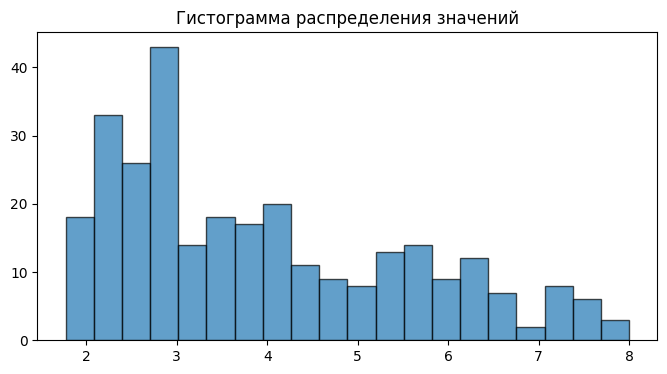

In [27]:
plt.figure(figsize=(8, 4))
plt.hist(data_interpolated, bins=20, edgecolor='k', alpha=0.7)
plt.title('Гистограмма распределения значений')
plt.show()

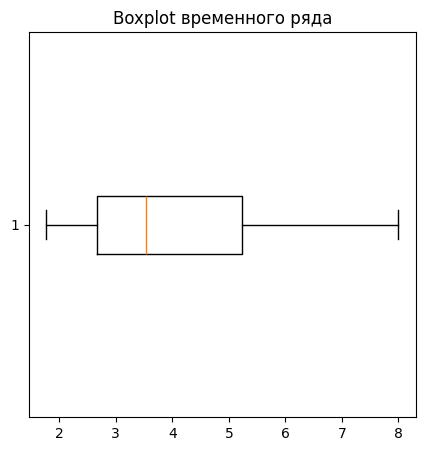

In [28]:
plt.figure(figsize=(5, 5))
plt.boxplot(data_interpolated, vert=False)
plt.title('Boxplot временного ряда')
plt.show()

## Проверка наличия тренда

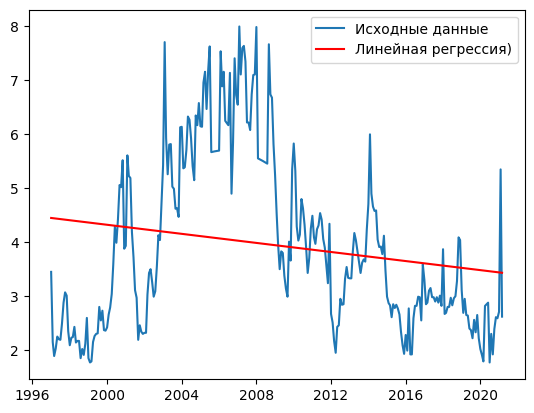

Коэффициент наклона : [-0.0035045]
Коэффициент детерминации (R²): 0.0340


In [29]:
# Построение линейной модели
X = np.arange(len(data_interpolated.index)).reshape(-1, 1)
y = data_interpolated[['Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)']]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

plt.plot(data_interpolated.index, y, label='Исходные данные')
plt.plot(data_interpolated.index, y_pred, label='Линейная регрессия)', color='red')
plt.legend()
plt.show()

print("Коэффициент наклона :", model.coef_[0])

# Проверка адекватности модели
r2 = r2_score(y, y_pred)
print(f"Коэффициент детерминации (R²): {r2:.4f}")

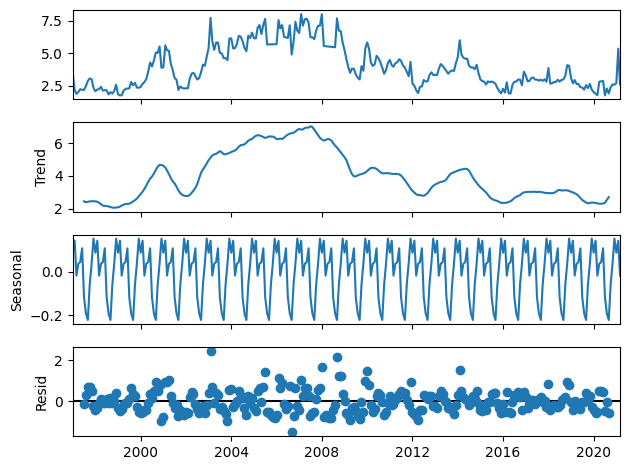

In [30]:
# Проверка наличия сезонности и цикличности
decompose = seasonal_decompose(y)
decompose.plot()
plt.show()

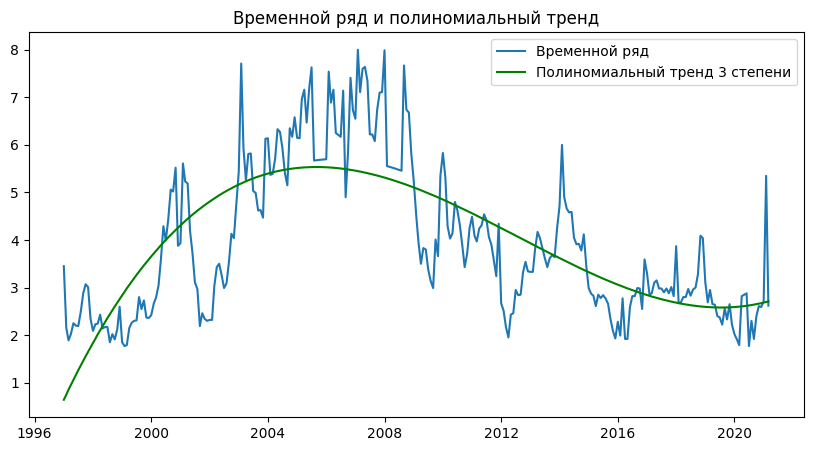

Коэффициент детерминации (R²) для полиномиальной модели: 0.5849


In [31]:
# Полиномиальная модель
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

poly_trend = poly_model.predict(X_poly)

plt.figure(figsize=(10, 5))
plt.plot(data_interpolated.index, data_interpolated, label='Временной ряд')
plt.plot(data_interpolated.index, poly_trend, label='Полиномиальный тренд 3 степени', color='green')
plt.legend()
plt.title('Временной ряд и полиномиальный тренд')
plt.show()

# Проверка адекватности модели
r2_poly = r2_score(y, poly_trend)
print(f"Коэффициент детерминации (R²) для полиномиальной модели: {r2_poly:.4f}")

## Построение моделей атворегрессии и скользящего среднего

In [32]:
# Преобразование в стационарный ряд
diff_data = data_interpolated.diff().dropna()

# Повторная проверка стационарности
result = adfuller(diff_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -14.613317579130461
p-value: 3.9906122689235996e-27


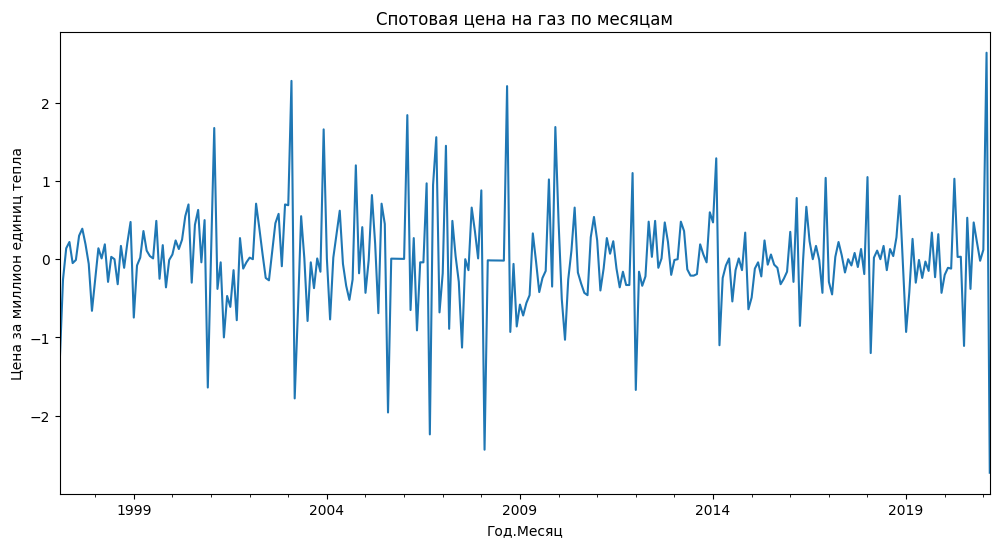

In [33]:
graph = diff_data.plot(figsize = (12,6), legend=None)

graph.set(title = 'Спотовая цена на газ по месяцам', 
          xlabel = 'Год.Месяц', 
          ylabel = 'Цена за миллион единиц тепла');

In [34]:
# Построение моделей

In [35]:
diff_data = diff_data.asfreq('MS')
# diff_data = diff_data[['Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)']]

In [36]:
# Разделение данных для краткосрочного прогноза (90/10)
train_size_short = int(len(diff_data) * 0.90)
train_short, test_short = diff_data.iloc[:train_size_short], diff_data.iloc[train_size_short:]

# Разделение данных для долгосрочного прогноза (75/25)
train_size_long = int(len(diff_data) * 0.75)
train_long, test_long = diff_data.iloc[:train_size_long], diff_data.iloc[train_size_long:]

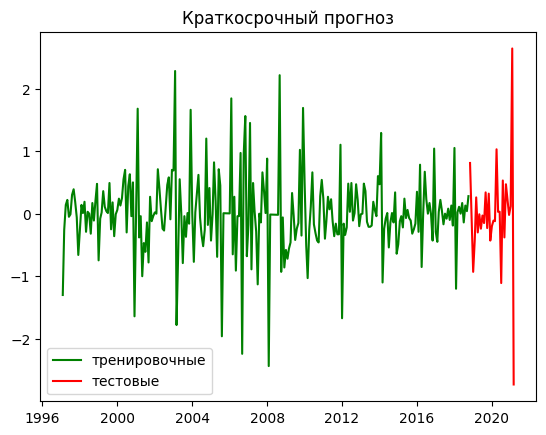

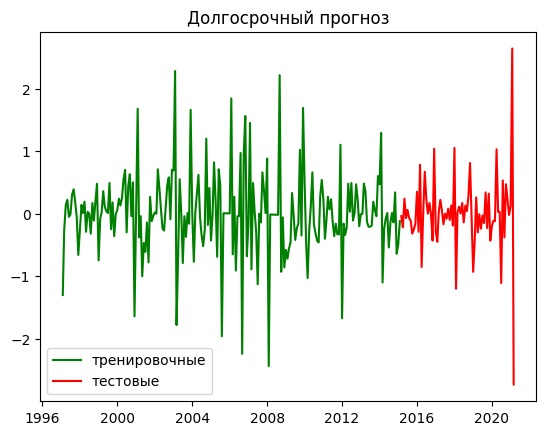

In [37]:
plt.plot(train_short, label='тренировочные', color='green')
plt.plot(test_short, label='тестовые', color='red')
plt.title('Краткосрочный прогноз')
plt.legend()
plt.show()

plt.plot(train_long, label='тренировочные', color='green')
plt.plot(test_long, label='тестовые', color='red')
plt.title('Долгосрочный прогноз')
plt.legend()
plt.show()

Лучший лаг: 83, AIC: 400.00061564728225
MSE: 0.7542
MAE: 0.5549
R-squared: -0.1009


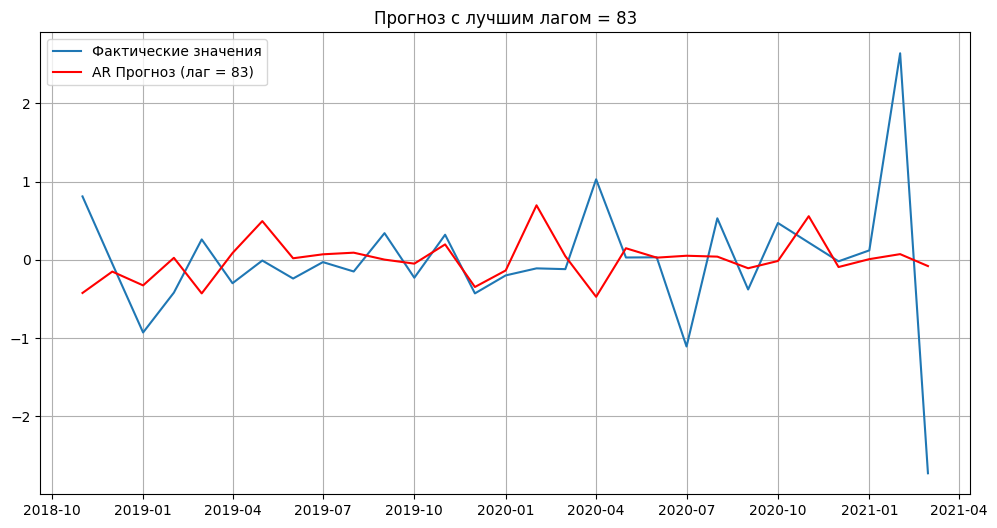

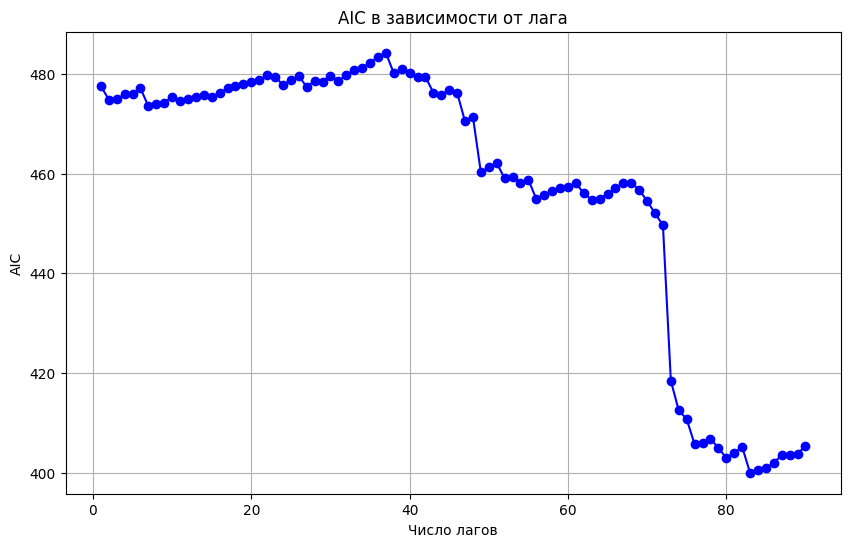

In [38]:
# Модель AR(p)

min_lag = 1
max_lag = 90
aic_values = []
best_lag = None
best_model = None
best_aic = np.inf

for lag in range(min_lag, max_lag + 1):
    model = AutoReg(train_short, lags=lag).fit()
    aic = model.aic
    aic_values.append(aic)
    
    if aic < best_aic:
        best_aic = aic
        best_lag = lag
        best_model = model

print(f"Лучший лаг: {best_lag}, AIC: {best_aic}")

pred = best_model.predict(start=len(train_short), end=len(train_short) + len(test_short) - 1, dynamic=False)

# Оценка качества модели
mse = mean_squared_error(test_short, pred)
mae = mean_absolute_error(test_short, pred)
r_squared = r2_score(test_short, pred)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(test_short, label='Фактические значения')
plt.plot(pred, label=f'AR Прогноз (лаг = {best_lag})', color='red')
plt.title(f'Прогноз с лучшим лагом = {best_lag}')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(min_lag, max_lag + 1), aic_values, marker='o', color='blue')
plt.title('AIC в зависимости от лага')
plt.xlabel('Число лагов')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

Лучший лаг: 83, AIC: 342.9514166470639
MSE: 0.5175
MAE: 0.5240
R-squared: -0.4153


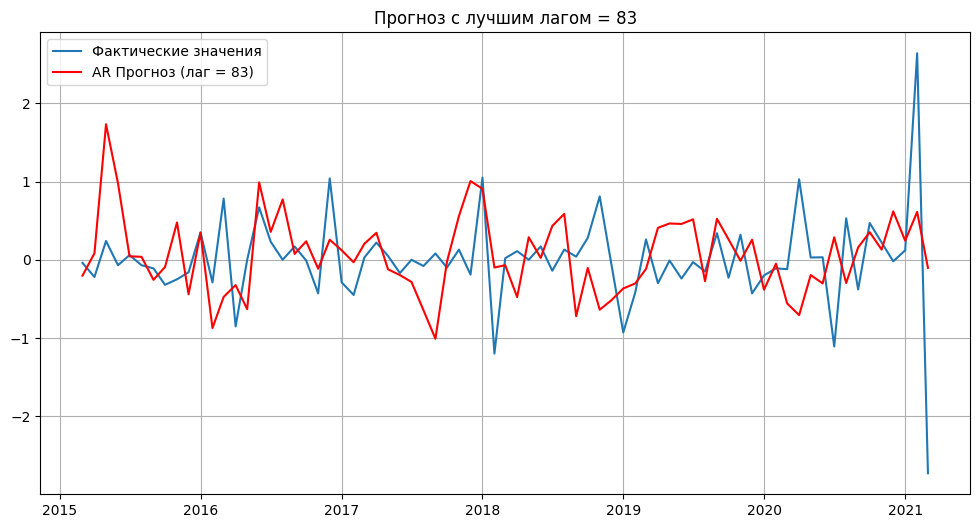

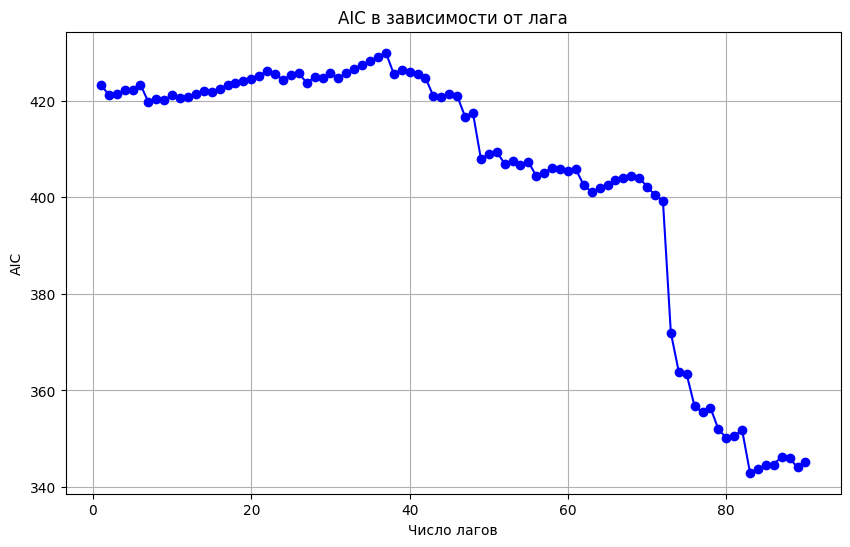

In [39]:
# Модель AR(p)

min_lag = 1
max_lag = 90
aic_values = []
best_lag = None
best_model = None
best_aic = np.inf  

for lag in range(min_lag, max_lag + 1):
    model = AutoReg(train_long, lags=lag).fit()
    aic = model.aic
    aic_values.append(aic)
    
    if aic < best_aic:
        best_aic = aic
        best_lag = lag
        best_model = model

print(f"Лучший лаг: {best_lag}, AIC: {best_aic}")

pred = best_model.predict(start=len(train_long), end=len(train_long) + len(test_long) - 1, dynamic=False)

mse = mean_squared_error(test_long, pred)
mae = mean_absolute_error(test_long, pred)
r_squared = r2_score(test_long, pred)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(test_long, label='Фактические значения')
plt.plot(pred, label=f'AR Прогноз (лаг = {best_lag})', color='red')
plt.title(f'Прогноз с лучшим лагом = {best_lag}')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(min_lag, max_lag + 1), aic_values, marker='o', color='blue')
plt.title('AIC в зависимости от лага')
plt.xlabel('Число лагов')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

Лучший лаг: 2, AIC: 480.2467363706752
MSE: 0.6894
MAE: 0.4929
R-squared: -0.0063


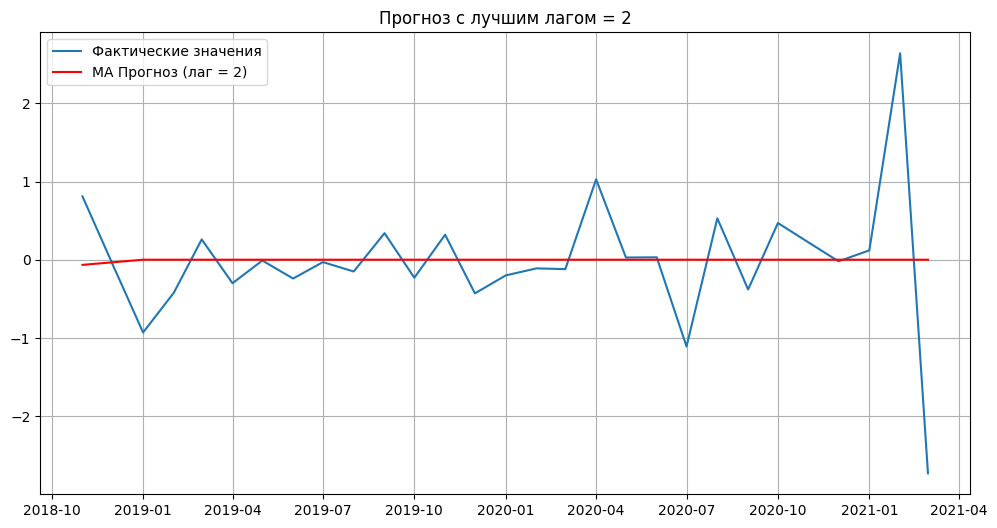

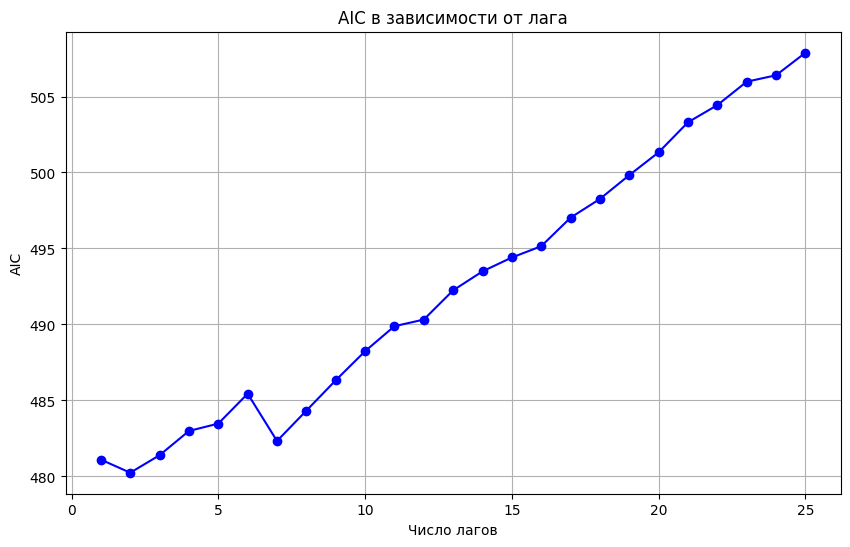

In [40]:
# Модель скользящего среднего (MA(q))

min_q = 1
max_q = 25
aic_values = []
best_q = None
best_model = None
best_aic = np.inf 

for lag in range(min_q, max_q + 1):
    model_ma = ARIMA(train_short, order=(0, 0, lag)).fit()
    aic = model_ma.aic
    aic_values.append(aic)
    
    if aic < best_aic:
        best_aic = aic
        best_q = lag
        best_model = model_ma

print(f"Лучший лаг: {best_q}, AIC: {best_aic}")

pred = best_model.predict(start=len(train_short), end=len(train_short) + len(test_short) - 1, dynamic=False)

mse = mean_squared_error(test_short, pred)
mae = mean_absolute_error(test_short, pred)
r_squared = r2_score(test_short, pred)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(test_short, label='Фактические значения')
plt.plot(pred, label=f'MA Прогноз (лаг = {best_q})', color='red')
plt.title(f'Прогноз с лучшим лагом = {best_q}')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(min_q, max_q + 1), aic_values, marker='o', color='blue')
plt.title('AIC в зависимости от лага')
plt.xlabel('Число лагов')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

D:\Python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Лучший лаг: 2, AIC: 426.52409893177224
MSE: 0.3662
MAE: 0.3521
R-squared: -0.0015


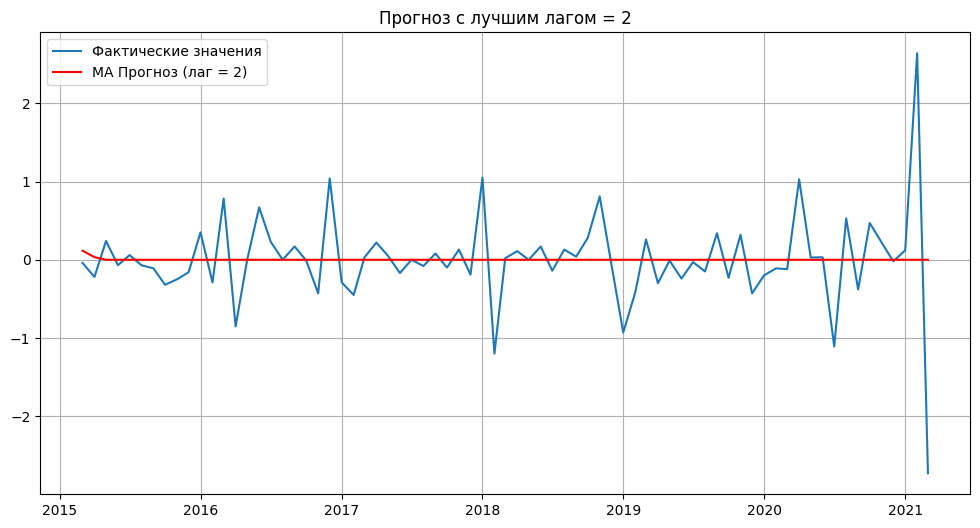

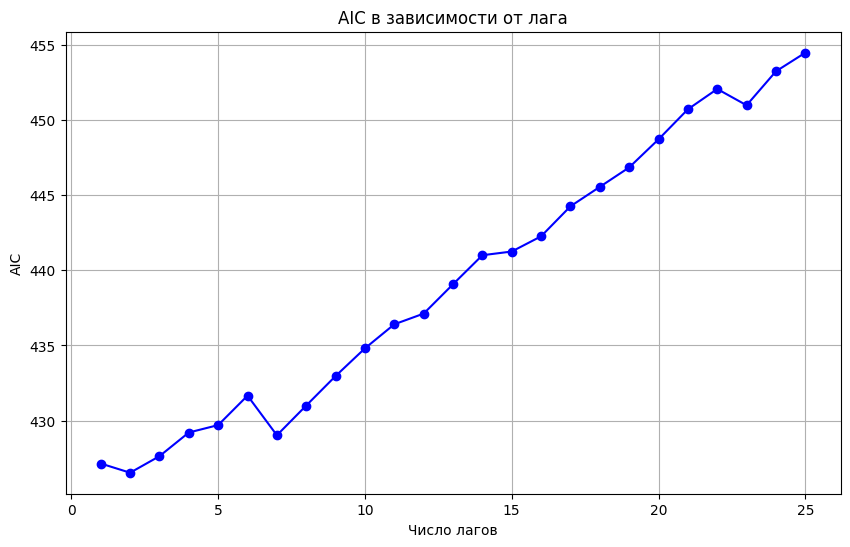

In [41]:
# Модель скользящего среднего (MA(q))

min_q = 1
max_q = 25
aic_values = []
best_q = None
best_model = None
best_aic = np.inf 

for lag in range(min_q, max_q + 1):
    model_ma = ARIMA(train_long, order=(0, 0, lag)).fit()
    aic = model_ma.aic
    aic_values.append(aic)
    
    if aic < best_aic:
        best_aic = aic
        best_q = lag
        best_model = model_ma

print(f"Лучший лаг: {best_q}, AIC: {best_aic}")

pred = best_model.predict(start=len(train_long), end=len(train_long) + len(test_long) - 1, dynamic=False)

mse = mean_squared_error(test_long, pred)
mae = mean_absolute_error(test_long, pred)
r_squared = r2_score(test_long, pred)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(test_long, label='Фактические значения')
plt.plot(pred, label=f'MA Прогноз (лаг = {best_q})', color='red')
plt.title(f'Прогноз с лучшим лагом = {best_q}')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(min_q, max_q + 1), aic_values, marker='o', color='blue')
plt.title('AIC в зависимости от лага')
plt.xlabel('Число лагов')
plt.ylabel('AIC')
plt.grid(True)
plt.show()

D:\Python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 0.6851
MAE: 0.4982
R-squared: -0.0000


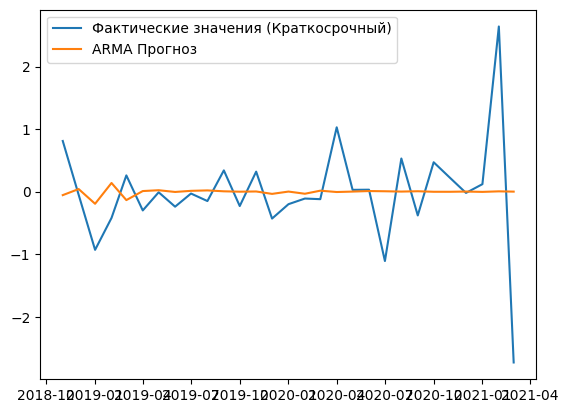

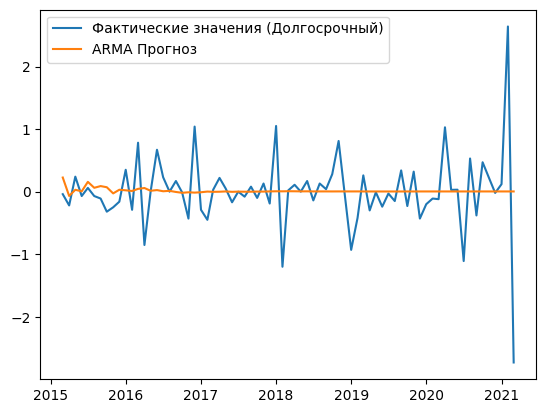

In [42]:
# Модель ARMA(p, q)

model_arma_short = ARIMA(train_short, order=(15, 0, 2)).fit()
pred_arma_short = model_arma_short.predict(start=len(train_short), end=len(train_short) + len(test_short) - 1, dynamic=False)

model_arma_long = ARIMA(train_long, order=(15, 0, 2)).fit()
pred_arma_long = model_arma_long.predict(start=len(train_long), end=len(train_long) + len(test_long) - 1, dynamic=False)

mse = mean_squared_error(test_short, pred_arma_short)
mae = mean_absolute_error(test_short, pred_arma_short)
r_squared = r2_score(test_short, pred_arma_short)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.plot(test_short, label='Фактические значения (Краткосрочный)')
plt.plot(pred_arma_short, label='ARMA Прогноз')
plt.legend()
plt.show()

plt.plot(test_long, label='Фактические значения (Долгосрочный)')
plt.plot(pred_arma_long, label='ARMA Прогноз')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=475.272, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=485.728, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=480.972, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=479.110, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=476.695, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=476.622, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=478.247, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=479.715, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=478.772, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=477.267, Time=0.21 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 1.405 seconds
Оптимальные параметры: (1, 0, 1)
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=421.122, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=428.534, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] 

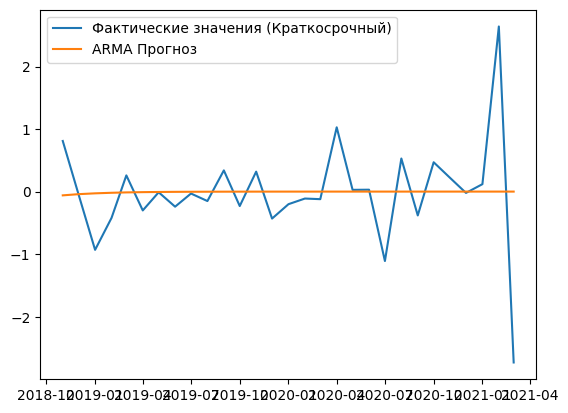

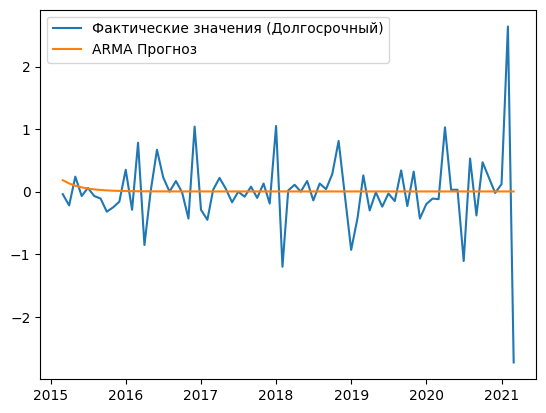

In [51]:
# Модель ARIMA(p, k, q)

model_auto = auto_arima(train_short, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, 
                        start_p=1, max_p=20,
                        start_d=1, max_d=3, 
                        start_q=1, max_q=10)

print(f'Оптимальные параметры: {model_auto.order}')

model_arima_short = ARIMA(train_short, order=model_auto.order).fit()
# model_arima_short = ARIMA(train_short, order=(5, 1, 5)).fit()
pred_arima_short = model_arima_short.predict(start=len(train_short), end=len(train_short) + len(test_short) - 1, dynamic=False)

model_auto = auto_arima(train_long, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True,
                        start_p=1, max_p=20,
                        start_d=1, max_d=3,
                        start_q=1, max_q=10)

print(f'Оптимальные параметры: {model_auto.order}')

model_arima_long = ARIMA(train_long, order=model_auto.order).fit()
# model_arima_long = ARIMA(train_long, order=(5, 1, 5)).fit()
pred_arima_long = model_arima_long.predict(start=len(train_long), end=len(train_long) + len(test_long) - 1, dynamic=False)

mse = mean_squared_error(test_short, pred_arima_short)
mae = mean_absolute_error(test_short, pred_arima_short)
r_squared = r2_score(test_short, pred_arima_short)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r_squared:.4f}')

plt.plot(test_short, label='Фактические значения (Краткосрочный)')
plt.plot(pred_arima_short, label='ARMA Прогноз')
plt.legend()
plt.show()

plt.plot(test_long, label='Фактические значения (Долгосрочный)')
plt.plot(pred_arima_long, label='ARMA Прогноз')
plt.legend()
plt.show()
